In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from scipy.io import savemat, loadmat
import matlab.engine # to run Cheng's code
import time

# add the path to my packages to system paths so they can be imported
import sys
sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
# sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import my_simgraph_06 as sg
import data_handler_03 as dh

# Create training and validation datasets

In [ ]:
data_sz = 13204 # all available mnist-sift datapoints
# consider all range
ind_min = 0
ind_max = 13203
train_num = 30
val_num = 10

# # load all the labels
# data_path = '../../data/fe_exp/mnist-sift/'
# lbls = np.loadtxt(data_path+'lbls.csv')

def get_mnist_labels(data_params):
    return np.loadtxt(data_params['features_dp']+'lbls.csv')

data_params = {'func': dh.datapoint_sift, 'lbl_func': get_mnist_labels, 'features_dp': '../../data/fe_exp/mnist-sift/', \
               'spike_data': None, 'group_id': None, 'transform': None, 'ind_min': 0, 'ind_max': 13203}

train_num, val_num, train_data, val_data = \
dh.random_train_val_balanced(train_num, val_num, data_params, seed=1324)

# show statistics
print('train_num = ', train_num, ', val_num = ', val_num)
print('# of features = ', train_data['des'].shape[1])
print('training data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(train_data['lbls'] == 1), np.sum(train_data['lbls'] == 1)*100/train_num))
print('validation data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(val_data['lbls'] == 1), np.sum(val_data['lbls'] == 1)*100/val_num))

# print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
# print('train_lbls = ', train_data['lbls'], '\nval_lbls = ', val_data['lbls'])
# print('train_des = ', train_data['des'], '\nval_des = ', val_data['des'])

## Save the data on disc for the Matlab code's use

In [3]:
# save the dataset on disc
data_path = '../../data/fe_exp/cheng_snap_2/'
savemat(data_path+'data_sift.mat', {'train_des': train_data['des'], 'train_lbls': train_data['lbls']})

# Learn the similarity graph with GDPA

In [ ]:
eng = matlab.engine.start_matlab()
eng.cd(r'/home/yasamanparhizkar/Documents/yorku/01_thesis/code/15_cheng', nargout=0)
M_gdpa = eng.lmnn_fit('sift')
M_gdpa = np.array(M_gdpa)

## Display learned metric matrix

Text(0.5, 1.0, 'M_gdpa - marked above 0%')

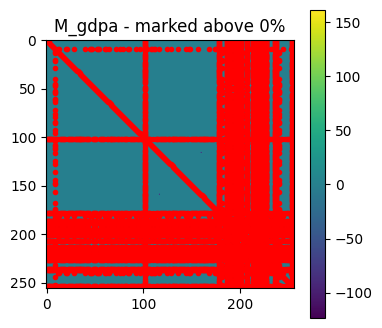

In [26]:
# display the optimized metric matrix
# print('M_gdpa = \n', M_gdpa)

sg.display_matrix(M_gdpa, None)
# mark elements with high values
thresh = 0
lim = (thresh/100) * np.max(M_gdpa) # marker threshold
f_sz = M_gdpa.shape[0]
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
plt.plot(xloc[M_gdpa > lim],yloc[M_gdpa > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M_gdpa - marked above {}%'.format(thresh))
# print('M_gdpa - Coordinates of elements with higher values than {}'.format(lim))
# print(list(zip(xloc[M_gdpa > lim],yloc[M_gdpa > lim])))

## Compute the final training loss of sg-gdpa

In [27]:
gamma = 1.0
V = eng.get_objective_variables_ready(train_data['des'], train_data['lbls'].reshape((train_num,1)), train_data['des'].shape[0], train_data['des'].shape[1], gamma)
V = np.array(V)

In [28]:
loss_gdpa = np.sum(M_gdpa * V.T)

print('GDPA loss with GDPA metric: {:.3f}'.format(loss_gdpa))

GDPA loss with GDPA metric: -1247.927


## Validate the similarity graph (GDPA)

In [29]:
# # reload sg package
# import importlib
# importlib.reload(sg)

In [30]:
# graph construction and penalty term parameters
sg_params = {'mu': 30, 'Dt': None, 'Dv': 0, 'Dvt': 2000, \
             'cnstr_method_tt': 'time', 'cnstr_method_vv': 'time', 'cnstr_method_vt': 'time',\
             'train_t': train_data['smpls'], 'val_t': val_data['smpls'], \
             'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

val_acc_gdpa, y_est_gdpa, t_gdpa = sg.get_acc(M_gdpa, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, seed=0, show_edges=False)
print('Elapsed time = {:.2f} ms'.format(t_gdpa*1000))

Elapsed time = 8.40 ms


In [31]:
print('val acc = {:.2f}%'.format(val_acc_gdpa*100))
print('elapsed time = {:.2f} ms'.format(t_gdpa*1000))
print('estimated val labels = ', 2*(y_est_gdpa>0).astype(np.int32)-1)

val acc = 80.00%
elapsed time = 8.40 ms
estimated val labels =  [ 1 -1  1  1  1 -1  1 -1 -1 -1]


In [32]:
# comparing estimated and real spike locations
val_loc = np.arange(val_num)
val_spikes = val_loc[val_data['lbls']==1]
est_spikes_gdpa = val_loc[y_est_gdpa > 0]

if sum(val_data['lbls']==1) == 0:
    missed_gdpa = 0
else:
    missed_gdpa = sum(np.logical_and(val_data['lbls']==1, y_est_gdpa < 0))/sum(val_data['lbls']==1)

if sum(val_data['lbls']==-1) == 0:
    false_alarm_gdpa = 0
else:
    false_alarm_gdpa = sum(np.logical_and(val_data['lbls']==-1, y_est_gdpa > 0))/sum(val_data['lbls']==-1)

nospk_per = np.sum(val_data['lbls']==-1)/val_num
min_acc = max(nospk_per, 1-nospk_per)

print('Estimated spike time bins: ', est_spikes_gdpa)
print('Real spike time bins: ', val_spikes)
print('{:.2f}% of validation points have label {} (= min accuracy)'.format(min_acc*100, -1 if nospk_per > 50 else 1))
print('Missed spikes (/all spikes): {:.2f}%'.format(missed_gdpa*100))
print('False spikes (/all no-spike bins): {:.2f}%'.format(false_alarm_gdpa*100))

Estimated spike time bins:  [0 2 3 4 6]
Real spike time bins:  [0 1 2 3 4]
50.00% of validation points have label 1 (= min accuracy)
Missed spikes (/all spikes): 20.00%
False spikes (/all no-spike bins): 20.00%


# Train the similarity graph with M = B.T @ B

In [33]:
# graph construction and penalty term parameters
# sg_params = {'mu': 30, 'Dt': None, 'Dv':0, 'Dvt':2000, \
#              'cnstr_method_tt': 'time', 'cnstr_method_vv': 'time', 'cnstr_method_vt': 'time',\
#              'train_t': train_data['smpls'], 'val_t': val_data['smpls'], \
#              'edges_tt':None, 'edges_vv':None, 'edges_vt':None, }

# gradient descent parameters
sg_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
                  'num_its':10, 'check_freq':1, 'print_checks':True, 'Theta0':None, \
                  'force_all_its': True, 'threshold': 0.01}

time0 = time.time()
B_fact, sg_stats_fact = sg.fit_graph(dess=train_data['des'], lbls=train_data['lbls'], graph_params=sg_params, opt_params=sg_opt_params, seed=0)
print('Elapsed time = {} sec'.format(time.time()-time0))

Number of training datapoints: 30
Number of features for each point: 256
mu = 30
   0: eps = 7.81e-03;  train loss (E) = 547.32
   1: eps = 7.81e-03;  train loss (E) = 354.41
   2: eps = 1.56e-02;  train loss (E) = 343.51
   3: eps = 7.81e-03;  train loss (E) = 335.42
   4: eps = 7.81e-03;  train loss (E) = 335.27
   5: eps = 7.81e-03;  train loss (E) = 333.20
   6: eps = 3.91e-03;  train loss (E) = 326.92
   7: eps = 7.81e-03;  train loss (E) = 326.06
   8: eps = 7.81e-03;  train loss (E) = 325.56
   9: eps = 7.81e-03;  train loss (E) = 325.24
Elapsed time = 0.6020722389221191 sec


## Display learned metric matrix

Text(0.5, 1.0, 'M_fact - marked above 30%')

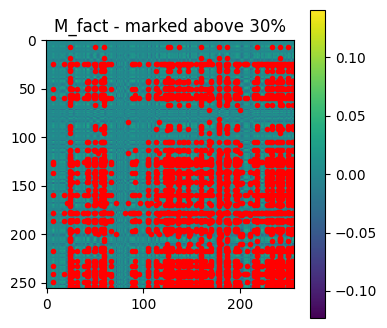

In [34]:
# display learned M
M_fact = B_fact.T @ B_fact

sg.display_matrix(M_fact, None)

# mark elements with high values
thresh = 30
lim = (thresh/100) * np.max(M_fact) # marker threshold
f_sz = M_fact.shape[0]
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
plt.plot(xloc[M_fact > lim],yloc[M_fact > lim], marker='o', markersize=3, color='r', linestyle='')
plt.title('M_fact - marked above {}%'.format(thresh))
# print('M_fact - Coordinates of elements with higher values than {:.2f}'.format(lim))
# print(list(zip(xloc[M_fact > lim],yloc[M_fact > lim])))

## Compute the final training loss of sg-factorization

In [35]:
loss_fact = sg.cnstr_glr(B_fact, deriv=False, mu=sg_params['mu'], x=train_data['lbls'], F=train_data['des'].T, edges_tt=sg_params['edges_tt'])

print('Factorization final loss: {:.3f}'.format(loss_fact))

Factorization final loss: 325.235


## Validate the similarity graph

In [36]:
val_acc_fact, y_est_fact, t_fact = sg.get_acc(M_fact, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'], sg_params, seed=0, show_edges=False)

In [37]:
print('val acc = {:.2f}%'.format(val_acc_fact*100))
print('elapsed time = {:.2f} ms'.format(t_fact*1000))
print('estimated val labels = ', 2*(y_est_fact>0).astype(np.int32)-1)

val acc = 100.00%
elapsed time = 12.05 ms
estimated val labels =  [ 1  1  1  1  1 -1 -1 -1 -1 -1]


In [38]:
# comparing estimated and real spike locations
est_spikes_fact = val_loc[y_est_fact > 0]

if sum(val_data['lbls']==1) == 0:
    missed_fact = 0
else:
    missed_fact = sum(np.logical_and(val_data['lbls']==1, y_est_fact < 0))/sum(val_data['lbls']==1)

if sum(val_data['lbls']==-1) == 0:
    false_alarm_fact = 0
else:
    false_alarm_fact = sum(np.logical_and(val_data['lbls']==-1, y_est_fact > 0))/sum(val_data['lbls']==-1)

nospk_per = np.sum(val_data['lbls']==-1)/val_num
min_acc = max(nospk_per, 1-nospk_per)

print('Estimated spike time bins: ', est_spikes_fact)
print('Real spike time bins: ', val_spikes)
print('{:.2f}% of validation points have label {} (= min accuracy)'.format(min_acc*100, -1 if nospk_per > 50 else 1))
print('Missed spikes (/all spikes): {:.2f}%'.format(missed_fact*100))
print('False spikes (/all no-spike bins): {:.2f}%'.format(false_alarm_fact*100))

Estimated spike time bins:  [0 1 2 3 4]
Real spike time bins:  [0 1 2 3 4]
50.00% of validation points have label 1 (= min accuracy)
Missed spikes (/all spikes): 0.00%
False spikes (/all no-spike bins): 0.00%


# Train the logistic regression model

In [19]:
data_path = '../../data/fe_exp/cheng_snap_2/'
temp = loadmat(data_path+'data_sift.mat')
train_des = temp['train_des']
train_lbls = temp['train_lbls']

In [27]:
train_des1 = train_des[::6,::16]
train_lbls1 = train_lbls[:,::6]
train_lbls1 = train_lbls1[0]

In [29]:
train_lbls1

array([ 1.,  1.,  1., -1., -1.])

In [31]:
# instantiate the model
lgrg = LogisticRegression(penalty='none')

# train the model  
# lgrg = lgrg.fit(train_data['des'], train_data['lbls'])
lgrg = lgrg.fit(train_des1, train_lbls1)

In [32]:
# print optimized parameters
print('classes = ', lgrg.classes_)
# print('decision boundary coefficients = ', lgrg.coef_)
print('decision boundary bias = ', lgrg.intercept_)
print('number of features seen during fit = ', lgrg.n_features_in_)
print('number of iterations done during fit = ', lgrg.n_iter_)

classes =  [-1.  1.]
decision boundary bias =  [-13.06114994]
number of features seen during fit =  16
number of iterations done during fit =  [18]


## Validate the logistic regression

In [ ]:
# validate the model
preds_lgrg = lgrg.predict(val_data['des'])
val_acc_lgrg = lgrg.score(val_data['des'], val_data['lbls'])

est_spikes_lgrg = val_loc[preds_lgrg > 0]
if sum(val_data['lbls']==1) == 0:
    missed_lgrg = 0
else:
    missed_lgrg = sum(np.logical_and(val_data['lbls']==1, preds_lgrg < 0))/sum(val_data['lbls']==1)
if sum(val_data['lbls']==-1) == 0:
    false_alarm_lgrg = 0
else:
    false_alarm_lgrg = sum(np.logical_and(val_data['lbls']==-1, preds_lgrg > 0))/sum(val_data['lbls']==-1)

print('Predicted labels WITH threshold =\n', preds_lgrg)
print('Validation accuracy =\n', val_acc_lgrg)
print('Estimated spike time bins: ', est_spikes_lgrg)
print('Real spike time bins: ', val_spikes)
print('Missed spikes (/all spikes): {:.2f}%'.format(missed_lgrg*100))
print('False spikes (/all no-spike bins): {:.2f}%'.format(false_alarm_lgrg*100))

## Substitute the factorization M into the GDPA objective

In [45]:
loss_fact = sg.cnstr_glr(B_fact, deriv=False, mu=sg_params['mu'], x=train_data['lbls'], F=train_data['des'].T, edges_tt=sg_params['edges_tt'])
loss_gdpa = np.sum(M_gdpa * V.T)
loss_fact_in_gdpa = np.sum(M_fact * V.T)

print('Factorization loss with factorization metric: {:.3f}'.format(loss_fact))
print('GDPA loss with GDPA metric: ', loss_gdpa)
print('GDPA loss with Factorization metric: ', loss_fact_in_gdpa)

Factorization loss with factorization metric: 325.235
GDPA loss with GDPA metric:  -1247.9273868121295
GDPA loss with Factorization metric:  -832.5358440052605


# Quite the matlab engine (otherwise would overuse RAM)

In [46]:
eng.quit()